In [1]:
# !pip install medmnist

In [2]:
# https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb

In [3]:
%load_ext autoreload
%autoreload 2 #1

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as F

from tqdm import tqdm

# from basic_vae import VariationalAutoencoder
# %aimport basic_vae

/home/ruben/anaconda3/envs/cv1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# data_flag = 'pathmnist'
# data_flag = 'breastmnist'
# data_flag = 'octmnist'
# data_flag = 'chestmnist'
data_flag = 'bloodmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.0001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


Using downloaded and verified file: /home/ruben/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/ruben/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/ruben/.medmnist/pathmnist.npz


In [6]:
train_dataset.imgs.shape

(89996, 28, 28, 3)

/home/ruben/anaconda3/envs/cv1/lib/python3.8/site-packages/medmnist/utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


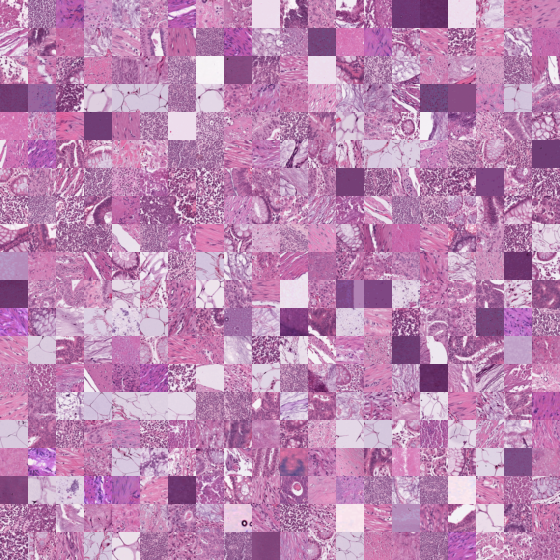

In [7]:
train_dataset.montage()

In [8]:
train_dataset.imgs.max()

255

In [9]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
    plt.show()

In [10]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12, latent_dim=2):
    w = 28
    img = np.zeros((n*w, n*w,3))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.randint(-1,1, (1,latent_dims), dtype=torch.float, device=device)
            # z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            # print(z)
            x_hat = x_hat.reshape(3, 28, 28).moveaxis(0,2).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w,:] = x_hat
    plt.figure(figsize=(10,10))
    plt.imshow(img, extent=[*r0, *r1])
    plt.show()

In [11]:
from basic_vae import VariationalAutoencoder

latent_dims = 32 #hyperparameter we can optimze?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vae = VariationalAutoencoder(latent_dims, mode="beta_vae", channels=3).to(device) # GPU

vae.train(train_loader, lr=0.0001, epochs=10, device=device)
# vae.train(train_loader, lr=0.0001, epochs=10, device=device)
# plot_latent(vae, train_loader)

100%|██████████| 704/704 [00:16<00:00, 43.53it/s]


Iteration: 0 Loss: 45998.68 Diff: 44854.11 KL: 1144.57 BCE: 0.0


100%|██████████| 704/704 [00:15<00:00, 45.91it/s]


Iteration: 1 Loss: 14362.14 Diff: 14073.67 KL: 288.47 BCE: 0.0


100%|██████████| 704/704 [00:15<00:00, 45.06it/s]


Iteration: 2 Loss: 9300.71 Diff: 9159.33 KL: 141.38 BCE: 0.0


100%|██████████| 704/704 [00:15<00:00, 45.19it/s]


Iteration: 3 Loss: 7695.09 Diff: 7607.88 KL: 87.21 BCE: 0.0


100%|██████████| 704/704 [00:15<00:00, 45.48it/s]


Iteration: 4 Loss: 6224.58 Diff: 6151.12 KL: 73.46 BCE: 0.0


100%|██████████| 704/704 [00:16<00:00, 43.33it/s]


Iteration: 5 Loss: 4992.7 Diff: 4934.03 KL: 58.67 BCE: 0.0


100%|██████████| 704/704 [00:16<00:00, 43.54it/s]


Iteration: 6 Loss: 4221.62 Diff: 4167.07 KL: 54.56 BCE: 0.0


100%|██████████| 704/704 [00:16<00:00, 43.57it/s]


Iteration: 7 Loss: 3743.07 Diff: 3686.58 KL: 56.49 BCE: 0.0


100%|██████████| 704/704 [00:16<00:00, 43.97it/s]


Iteration: 8 Loss: 3415.75 Diff: 3358.4 KL: 57.34 BCE: 0.0


100%|██████████| 704/704 [00:16<00:00, 42.74it/s]

Iteration: 9 Loss: 3184.87 Diff: 3127.98 KL: 56.89 BCE: 0.0


In [42]:
vae.train(train_loader, lr=0.0001, epochs=10, device=device)

100%|██████████| 704/704 [00:16<00:00, 42.00it/s]


Iteration: 0 Loss: 2158.61 Diff: 2129.1 KL: 29.51 BCE: 0.0


100%|██████████| 704/704 [00:15<00:00, 45.07it/s]


Iteration: 1 Loss: 2150.43 Diff: 2122.11 KL: 28.32 BCE: 0.0


100%|██████████| 704/704 [00:15<00:00, 44.26it/s]


Iteration: 2 Loss: 2127.8 Diff: 2101.19 KL: 26.61 BCE: 0.0


100%|██████████| 704/704 [00:16<00:00, 43.72it/s]


Iteration: 3 Loss: 2122.0 Diff: 2096.76 KL: 25.25 BCE: 0.0


100%|██████████| 704/704 [00:15<00:00, 44.43it/s]


Iteration: 4 Loss: 2109.55 Diff: 2085.56 KL: 24.0 BCE: 0.0


100%|██████████| 704/704 [00:16<00:00, 43.18it/s]


Iteration: 5 Loss: 2106.48 Diff: 2083.54 KL: 22.94 BCE: 0.0


100%|██████████| 704/704 [00:15<00:00, 44.05it/s]


Iteration: 6 Loss: 2098.27 Diff: 2076.33 KL: 21.93 BCE: 0.0


100%|██████████| 704/704 [00:15<00:00, 44.58it/s]


Iteration: 7 Loss: 2091.39 Diff: 2070.24 KL: 21.16 BCE: 0.0


100%|██████████| 704/704 [00:15<00:00, 44.71it/s]


Iteration: 8 Loss: 2082.39 Diff: 2062.15 KL: 20.24 BCE: 0.0


100%|██████████| 704/704 [00:15<00:00, 45.03it/s]

Iteration: 9 Loss: 2085.24 Diff: 2065.67 KL: 19.57 BCE: 0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 28, 28])


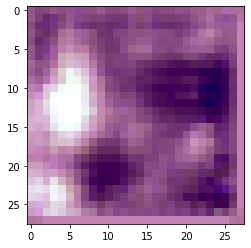

In [43]:
z = torch.randint(-1,1, (1,latent_dims), dtype=torch.float, device=device)
img = vae.decoder.forward(z)
print(img.shape)
# img = F.normalize(img)
plt.imshow(img.moveaxis(1,3).cpu().detach().numpy()[0], cmap="gray")
# plt.imshow(img.moveaxis(1, 3).cpu().detach().numpy()[0])
plt.show()

In [53]:
test_img = test_dataset[550][0][None,:,:,:].to(device)
lat = vae.encoder.forward(test_img)
img = vae.decoder.forward(lat)

[]

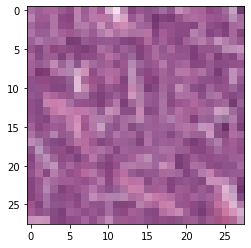

In [54]:
plt.imshow(test_img[0].moveaxis(0, 2).cpu().detach().numpy(), cmap="gray")
plt.plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[]

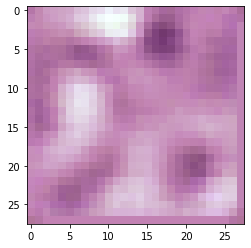

In [55]:
plt.imshow(img[0].moveaxis(0, 2).cpu().detach().numpy(), cmap="gray")
plt.plot()

In [26]:
lat[0,0]

tensor(-0.3949, device='cuda:0', grad_fn=<SelectBackward0>)

[]

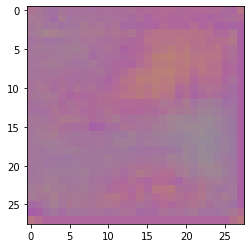

In [29]:
lat[0,18] -= 0.5

img = vae.decoder.forward(lat)
img = F.normalize(img)
plt.imshow(img[0].moveaxis(0, 2).cpu().detach().numpy(), cmap="gray")
plt.plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


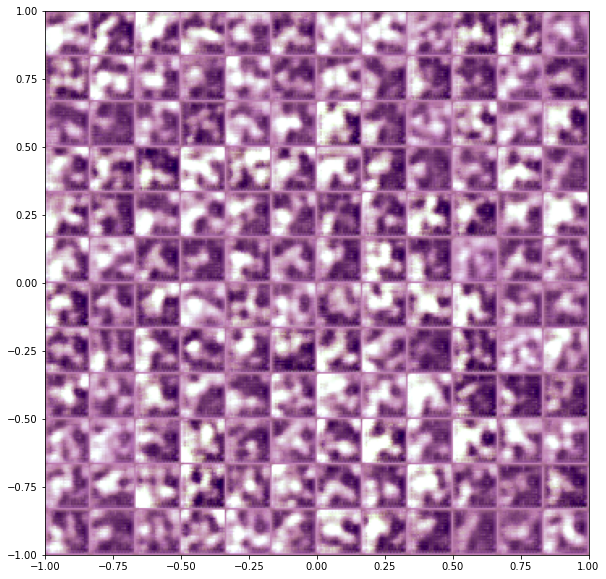

In [35]:
plot_reconstructed(vae, r0=(-1, 1), r1=(-1, 1), latent_dim=latent_dims)

In [20]:
lat

tensor([[-0.3949, -0.0778,  0.0516,  0.2843,  0.2486,  0.4671, -0.0054, -0.2327,
          0.2002,  0.1571, -0.5452,  0.2520,  0.0347, -0.3631,  0.1314, -0.2102,
         -0.1966, -0.6150, -1.0850,  0.1243, -0.0503, -0.0902, -0.1423,  0.1547,
         -0.2422, -0.0199, -0.5529,  0.4102, -0.4452, -0.6347,  0.2424,  0.4027]],
       device='cuda:0', grad_fn=<CopySlices>)

# New Section

In [41]:
i = torch.randn((3, 28, 28))
cov1 = nn.Conv2d(3, 4, 3, stride=1)
cov2 = nn.Conv2d(4, 5, 3, stride=2)
m1 = nn.MaxPool2d(2)
m2 = nn.MaxUnpool2d(2)
cov3 = nn.ConvTranspose2d(5,4,3, stride=2, output_padding=1)
cov4 = nn.ConvTranspose2d(4,3,3, stride=1)#, output_padding=1)
cov5 = nn.ConvTranspose2d(3,3,1, stride=1)#, output_padding=1)
print(i.flatten().shape, i.shape)
x = cov1(i)
x = cov2(x)
# x, ind = m1(x)
print(x.flatten().shape, x.shape)
x = cov3(x)
x = cov4(x)
x = cov5(x)
# x = m2(x, ind)
print(x.flatten().shape, x.shape)


torch.Size([2352]) torch.Size([3, 28, 28])
torch.Size([720]) torch.Size([5, 12, 12])
torch.Size([2352]) torch.Size([3, 28, 28])
